In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn import preprocessing

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset

import matplotlib.pyplot as plt

In [2]:
# Load CSV and clean data
data = pd.read_csv('weatherHistory.csv')

# Column 'Loud Cover' is always 0
data = data.drop(columns=['Loud Cover'])

# 0 Pressure is a vaccum, that data is not good
data = data.drop(data.loc[data['Pressure (millibars)'] == 0].index)

# Remove rarely occuring strings
for column in data:
    if data[column].dtype == object and column != 'Formatted Date':
        percentages = data[column].value_counts()/len(data)*100

        data = data[~data[column].isin(percentages[percentages <= 0.0015].index)]

# Duplicate values for dates, so remove them
data.drop_duplicates(subset=['Formatted Date'], inplace=True)

data = data.iloc[:1000]

# Split training and testing. 80%-20%
training_data, testing_data = data.iloc[:int(.10*len(data))], data.iloc[int(.10*len(data)):] 

# Fix indicies
training_data.reset_index(inplace=True, drop=True)
testing_data.reset_index(inplace=True, drop=True)
data.reset_index(inplace=True, drop=True)

data

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...
995,2006-08-02 15:00:00.000 +0200,Mostly Cloudy,rain,24.961111,24.961111,0.62,15.8746,290.0,11.2700,1008.75,Mostly cloudy throughout the day.
996,2006-08-02 16:00:00.000 +0200,Mostly Cloudy,rain,24.794444,24.794444,0.58,17.0338,319.0,11.2700,1008.94,Mostly cloudy throughout the day.
997,2006-08-02 17:00:00.000 +0200,Mostly Cloudy,rain,23.755556,23.755556,0.62,20.1572,319.0,11.4471,1008.76,Mostly cloudy throughout the day.
998,2006-08-02 18:00:00.000 +0200,Mostly Cloudy,rain,22.127778,22.127778,0.68,21.8316,319.0,11.2700,1008.95,Mostly cloudy throughout the day.


In [3]:
# Format the range of values and percent occurances for each column
for i, column in enumerate(data):
    if column == 'Formatted Date':
        continue
    elif data[column].dtype != object:
        print(f'Range of values for {column}:',end='\n\n')
        print(data[column].min(), '-', data[column].max(), end='\n\n')
    
    print(f'Percentage occurrence of {column}:',end='\n\n')
    print(data[column].value_counts()/len(data)*100, end='\n\n')
        
    if i != len(data.columns) - 1:
        print("-"*100,end='\n\n')

Percentage occurrence of Summary:

Partly Cloudy               35.3
Mostly Cloudy               35.0
Overcast                    16.6
Clear                        9.2
Foggy                        3.7
Breezy and Mostly Cloudy     0.2
Name: Summary, dtype: float64

----------------------------------------------------------------------------------------------------

Percentage occurrence of Precip Type:

rain    100.0
Name: Precip Type, dtype: float64

----------------------------------------------------------------------------------------------------

Range of values for Temperature (C):

0.9555555555555548 - 32.544444444444444

Percentage occurrence of Temperature (C):

17.266667    0.5
12.755556    0.5
17.800000    0.5
12.244444    0.5
17.777778    0.4
            ... 
22.316667    0.1
22.111111    0.1
22.777778    0.1
21.216667    0.1
21.061111    0.1
Name: Temperature (C), Length: 771, dtype: float64

-----------------------------------------------------------------------------------

In [4]:
data.corr(numeric_only=True)

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Temperature (C),1.000000,0.992941,-0.578251,0.016510,-0.103035,0.111905,-0.078151
Apparent Temperature (C),0.992941,1.000000,-0.567332,-0.035472,-0.120490,0.115936,-0.051267
Humidity,-0.578251,-0.567332,1.000000,-0.312651,0.080424,-0.176156,-0.046172
Wind Speed (km/h),0.016510,-0.035472,-0.312651,1.000000,0.083452,0.025148,-0.383595
Wind Bearing (degrees),-0.103035,-0.120490,0.080424,0.083452,1.000000,-0.077556,-0.040975
Visibility (km),0.111905,0.115936,-0.176156,0.025148,-0.077556,1.000000,-0.056804
Pressure (millibars),-0.078151,-0.051267,-0.046172,-0.383595,-0.040975,-0.056804,1.000000


In [13]:

def prepare_data(dataframe):
    # Normalize Data
    scaler = preprocessing.MinMaxScaler()
    numeric_columns = dataframe.select_dtypes(include=np.number).columns
    input = scaler.fit_transform(dataframe[numeric_columns])

    return input

days_before = 25

# Data 
training_dataset = TensorDataset(torch.tensor(prepare_data(training_data), dtype=torch.float64), torch.tensor(range(len(training_data)), dtype=torch.int64))
training_dataloader = DataLoader(TensorDataset(*training_dataset[days_before:]), batch_size=16, shuffle=True, drop_last=True)

testing_dataset = TensorDataset(torch.tensor(prepare_data(testing_data), dtype=torch.float64), torch.tensor(range(len(testing_data)), dtype=torch.int64))
testing_dataloader = DataLoader(TensorDataset(*testing_dataset[days_before:]), batch_size=16, shuffle=True, drop_last=True)

def get_data(dataset, batch):
    y, i = batch
    # Get temperature
    y = torch.tensor([j[0] for j in y], dtype=torch.float64)

    # input values are days_before values before 
    X = torch.tensor([dataset[j-days_before: j][0].tolist() for j in i], dtype=torch.float64)
    return X, y

In [14]:
def test(X, y, model, device, loss):
    out = model(X.to(device))
    
    return loss(out.flatten(), torch.reshape(y, out.flatten().shape).to(device)), out
    
def train(X,y, model, device, loss, opt):
    l, out = test(X, y, model, device, loss)
    
    l.backward()
    opt.step()
    opt.zero_grad()
    
    return l

In [15]:
class GRU_model(nn.Module):
    def __init__(self):
        super(GRU_model, self).__init__()
        # Features, Hidden Layer Size, Number of layers
        self.gru = nn.GRU(7, 100, 3, dtype=torch.float64)
        self.l = nn.Linear(100, 1, dtype=torch.float64)
    def forward(self, x):
        x, hidden = self.gru(x)
        x = self.l(x[:,-1,:])
        return x

In [16]:
if __name__ == "__main__":
    device = torch.device("cuda:0")
    model = GRU_model().to(device=device)
    loss = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 10
    
    training_losses = []
    testing_losses = []
    
    final_out = []
    final_y = []
    for e in range(epochs):
        # Train model
        training_loss = 0
        for batch in training_dataloader:
            values = get_data(training_dataset, batch)
            
            
            l = train(*values, model, device, loss, opt)
            training_loss += l.cpu().detach().item()

        # Test model
        testing_loss = 0
        for batch in testing_dataloader:
            values = get_data(testing_dataset, batch)
            
            X, y = values

            l, out = test(X, y, model, device, loss)
            
            testing_loss += l.cpu().detach().item()
            
            # Put final test output in dataframe 
            if (e == epochs-1):
                final_out.extend(out.flatten().cpu().detach().numpy())
                final_y.extend(y.flatten().cpu().detach().numpy())
            
        
        
        training_loss /= len(training_data)
        training_losses.append(training_loss)
        testing_loss /= len(testing_data)
        testing_losses.append(testing_loss)
        
        print(f"Epoch {e+1}/{epochs}:")
        print("Training loss = ", training_loss)
        print("Testing loss = ", testing_loss)


output = pd.DataFrame({'Expected Temperature': final_y,
               'Predicted Temperature': final_out})        
output.to_csv("out.csv")


# Pearson correlation
correlation = stats.pearsonr(output['Expected Temperature'], output['Predicted Temperature'])
print("Correlation:", correlation[0])

Epoch 1/10:
Training loss =  tensor(0.0073, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss =  tensor(0.0029, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Epoch 2/10:
Training loss =  tensor(0.0037, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss =  tensor(0.0027, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Epoch 3/10:
Training loss =  tensor(0.0036, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss =  tensor(0.0045, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Epoch 4/10:
Training loss =  tensor(0.0031, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss =  tensor(0.0020, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Epoch 5/10:
Training loss =  tensor(0.0030, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss =  tensor(0.0024, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Epoch

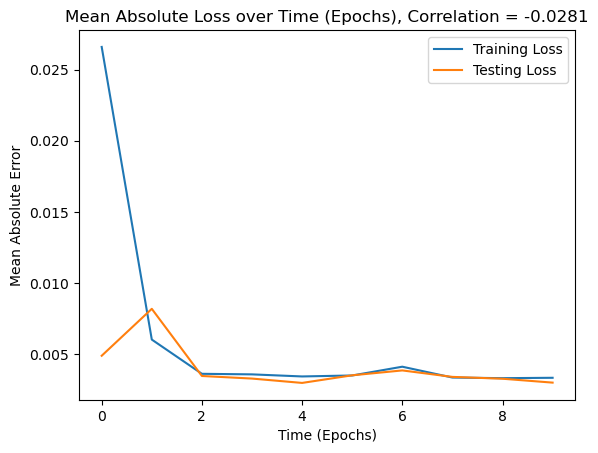

In [10]:
plt.plot(np.arange(epochs), [x for x in training_losses], label="Training Loss")
plt.plot(np.arange(epochs), [x for x in testing_losses], label="Testing Loss")

plt.title(f'Mean Absolute Loss over Time (Epochs), Correlation = {round(correlation[0],4)}')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Time (Epochs)')

plt.legend()
plt.show()